In [1]:
import keras
import os
import cv2
import numpy as np  
import pandas as pd 
import seaborn as sns     
import tensorflow as tf 
from tabulate import tabulate
from termcolor import colored  
import matplotlib.pyplot as plt  
from IPython.display import display
from keras.models import Sequential
from keras import models, layers, optimizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Reshape
sns.set_style('whitegrid')

2024-08-17 17:27:16.129585: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 17:27:16.129652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 17:27:16.131103: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dir1 = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
# Detect classes
detection = [class_name for class_name in os.listdir(dir1) if class_name]
detection.remove('Rice_Citation_Request.txt')
print(detection)

['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']


In [3]:
# Create a list of tuples that contain image paths and their class labels
image_data = []  # Initialize an empty list for storing image paths and labels

# Iterate through each class in the detection
for class_name in detection:
    class_path = os.path.join(dir1, class_name)  # Create the path for the class
    files = os.listdir(class_path)  # List all files in the class folder
    
    # Loop through all files and add their paths and class labels to the image_data list
    for file in files:
        file_path = os.path.join(class_path, file)  # Create the full file path
        image_data.append((file_path, class_name))  # Append tuple to the list
        
   # Convert the list to a pandas DataFrame
df = pd.DataFrame(image_data, columns=['path', 'label'])

# Shuffle the DataFrame rows for randomness
df = df.sample(frac=1).reset_index(drop=True)

# Display the first few entries of the DataFrame
display(df.head())  # Change from print to display     

,path,label
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Basmati
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Ipsala
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Basmati
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Basmati


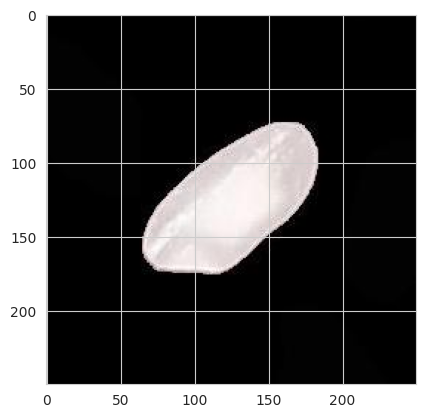

In [4]:
img = cv2.imread(df.iloc[0]['path'])
plt.imshow(img)

In [5]:
img.shape

(250, 250, 3)

In [6]:
img[20:30]

array([[[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [7]:
training_data = df[:60000]
validation_data = df[60000:67500]
test_data = df[67500:]

# Set image dimensions and batch size
IMAGE_SIZE = (250, 250)
BATCH_SIZE = 16

# Initialize the ImageDataGenerator for image normalization
data_gen = ImageDataGenerator(rescale=1.0/255)

# Function to create data generators
def create_data_generator(dataframe, is_training=False):
    return data_gen.flow_from_dataframe(
        dataframe,
        x_col='path',
        y_col='label',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=is_training)

# Create generators for training, validation, and test datasets
train_generator = create_data_generator(training_data, is_training=True)
valid_generator = create_data_generator(validation_data, is_training=False)
test_generator = create_data_generator(test_data, is_training=False)

Found 60000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.


In [8]:
model = Sequential()
model.add(Conv2D(512,(5,5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))



In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=5, validation_data=valid_generator)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-08-17 17:28:33.380919: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[512,3,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,250,250]{3,2,1,0}, f32[16,512,246,246]{3,2,1,0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-17 17:28:33.815055: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.434276696s
Trying algorithm eng0{} for conv (f32[512,3,5,5]{3,2,1

   1/3750 ━━━━━━━━━━━━━━━━━━━━ 27:49:07 27s/step - accuracy: 0.1875 - loss: 1.6113

I0000 00:00:1723915723.114241     331 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3750/3750 ━━━━━━━━━━━━━━━━━━━━ 501s 126ms/step - accuracy: 0.9195 - loss: 0.2461 - val_accuracy: 0.9673 - val_loss: 0.1453
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 467s 124ms/step - accuracy: 0.9723 - loss: 0.0814 - val_accuracy: 0.9732 - val_loss: 0.0977
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 465s 124ms/step - accuracy: 0.9773 - loss: 0.0664 - val_accuracy: 0.9737 - val_loss: 0.0999
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 465s 124ms/step - accuracy: 0.9826 - loss: 0.0526 - val_accuracy: 0.9757 - val_loss: 0.1002
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 465s 124ms/step - accuracy: 0.9866 - loss: 0.0368 - val_accuracy: 0.9760 - val_loss: 0.1189


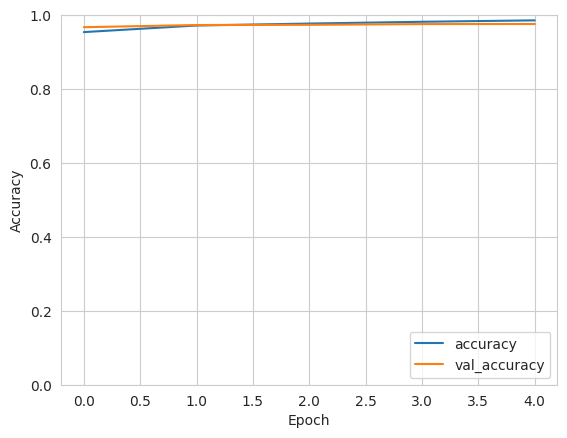

469/469 - 19s - 41ms/step - accuracy: 0.9749 - loss: 0.1433
3750/3750 - 143s - 38ms/step - accuracy: 0.9895 - loss: 0.0300


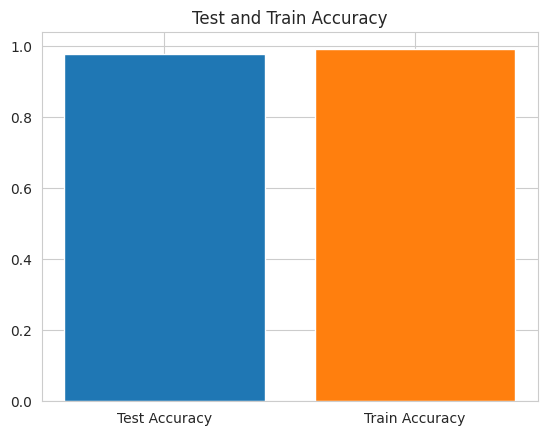

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_generator, verbose=2)
train_loss, train_acc = model.evaluate(train_generator, verbose=2)

plt.bar('Test Accuracy', test_acc)
plt.bar('Train Accuracy', train_acc)
plt.title('Test and Train Accuracy')
plt.show()

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step


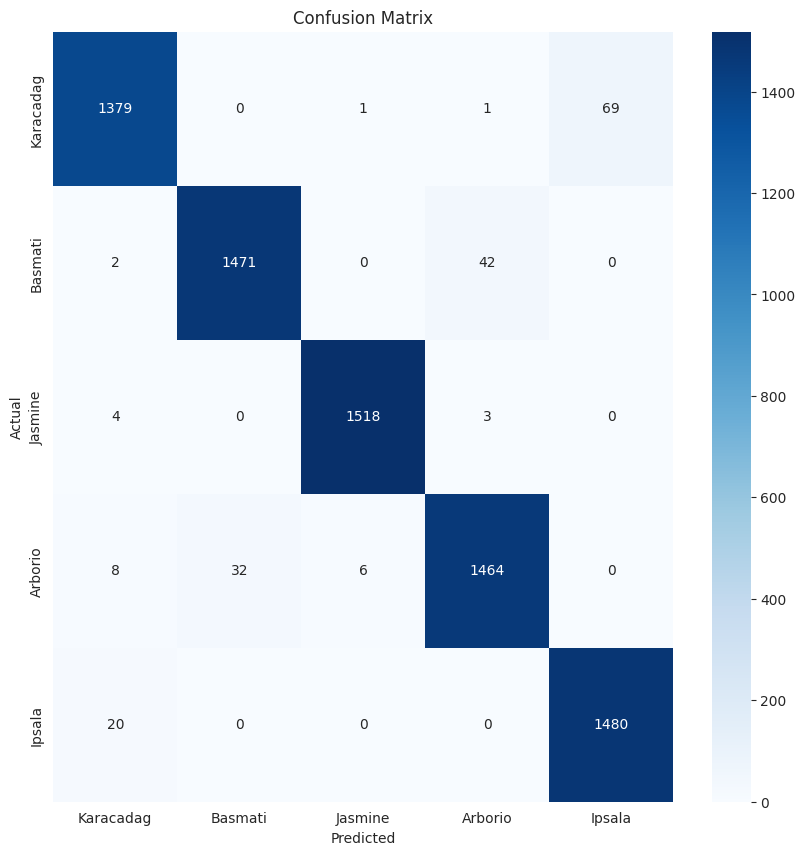

In [12]:
# confusion matrix
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=detection, yticklabels=detection)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()